## Computational Perception Assignment 2
Brennan McFarland

### Imports

In [1]:
import numpy as np
import random
import matplotlib.pyplot as plt
from matplotlib.pyplot import imread
import pywt
from sklearn.decomposition import PCA, FastICA as ICA
from skimage.color import rgb2gray

### Q1. Entropy (30 points)

1.1 (5 points) Write code to generate $N$ random samples from a 1) a uniform distribution, 2) a normal distribution, and 3) a sparse (leptokurtic) distribution of your choosing (or whatever is available in your the statistics library).  Plot histograms for your samples.

For my leptokurtic distribution, I chose the laplace.

In [243]:
def my_uniform(n, low=0.0, high=1.0):
    return np.array([np.random.uniform(low, high) for _ in range(n)])

def my_normal(n, mu=.5, sigma=.25):
    return np.array([np.random.normal(mu, sigma) for _ in range(n)])

def my_sparse(n, loc=.5, scale=.1):
    return np.array([np.random.laplace(loc, scale) for _ in range(n)])

In [244]:
# test the distributions by matching against numpy functions with the same random seed

def seed_random_constant():
    random.seed(24601) # who am I?
    np.random.seed(24601)

my_funcs = (my_uniform, my_normal, my_sparse)
func_names = ('uniform', 'normal', 'laplace')
np_funcs = (
    np.random.uniform,
    lambda size: np.random.normal(loc=.5, scale=.25, size=size),
    lambda size: np.random.laplace(loc=.5, scale=.1, size=size)
)

n = 5
for func_name, my_func, np_func in zip(func_names, my_funcs, np_funcs):
    seed_random_constant()
    my_output = my_func(n)
    seed_random_constant()
    
    np_output = np_func(size=n)
    difference = my_output - np_output
    #print(func_name, " My output: ",my_output, " Numpy output: ", np_output, " Difference: ", difference)
    assert np.array_equal(my_output, np_output)
print("No assertion failures, all functions equivalent")

No assertion failures, all functions equivalent


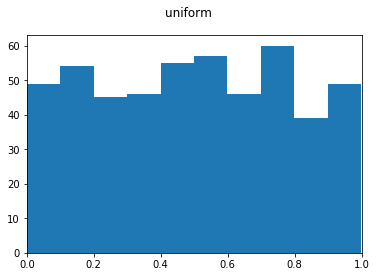

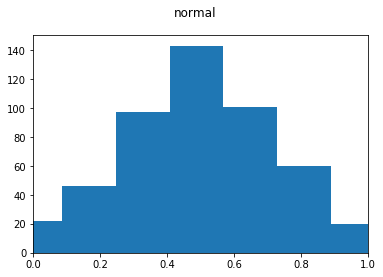

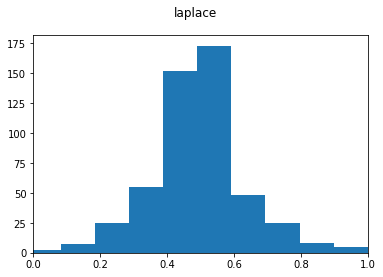

In [246]:
# plot histograms
n=500
for func_name, my_func in zip(func_names, my_funcs):
    histogram = np.histogram(my_func(n))  
    plt.hist(my_func(n))
    plt.xlim((0, 1))
    plt.gcf().suptitle(func_name)
    plt.show()

1.2 (5 points) Write a function that *computes* a histogram (e.g. computes the counts for a set of bins).  You can use library functions (e.g. in [fit(Histogram, ...)](http://juliastats.github.io/StatsBase.jl/latest/empirical.html#Histograms) in julia or [numpy.histogram](https://docs.scipy.org/doc/numpy-1.15.0/reference/generated/numpy.histogram.html) in python)).  Your bins should be evenly spaced within a range.

In [247]:
def compute_histogram(arr, hist_bins=10, hist_range=(-1, 1)):
    histogram = np.histogram(arr, bins=hist_bins, range=hist_range)
    return histogram

In [248]:
# for good measure, here's a function to plot it
def plot_histogram(histogram):
    plt.bar(histogram[1][:-1], histogram[0]) # we get rid of the last element because we don't need the upper bound of the max
    plt.show()

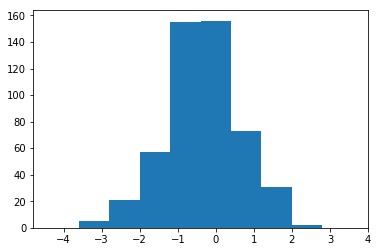

In [249]:
# test the function on a normal distribution
histogram = compute_histogram(np.random.normal(size=500), hist_range=(-4, 4))
plot_histogram(histogram)

1.3 (5 points) Write a function to calculate the entropy

$$
-\sum_x p(x) \log_2 p(x)
$$
given a vector of counts.  It should properly handle bins with zero count. 

In [250]:
# the entropy can of course be >1 because it's not binary
def entropy(counts):
    probs = counts / np.sum(counts)
    log_probs = np.log2(probs)
    entropy = -np.nansum(probs*log_probs) # nansum makes it treat log(0) as 0 (since it returns nan), so 0 counts work
    return entropy

In [251]:
# test on normal distribution
counts = compute_histogram(np.random.normal(size=500), hist_range=(-4, 4))[0]
ent = entropy(counts)
print(ent)

2.3892136823434194


/home/iamroot/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: RuntimeWarning: divide by zero encountered in log2
  after removing the cwd from sys.path.
/home/iamroot/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: RuntimeWarning: invalid value encountered in multiply
  """


1.4 (5 points) Estimate the entropy using the distributions above, using $2^k$ bins and the same bin boundaries for each.  Explain the differences in the entropy estimates and how they compare to the capacity of a $k$-bit binary code.

In [252]:
k = 5
bins = 2 ** k
n = 1000

for func_name, my_func in zip(func_names, my_funcs):
    counts = compute_histogram(my_func(n), hist_bins=bins, hist_range=(0, 1))[0]
    ent = entropy(counts)
    print(func_name, ent)
print('capacity ', np.log2(n))

uniform 4.984536332963493
normal 4.813968774033491
laplace 4.0031883039158656
capacity  9.965784284662087


/home/iamroot/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: RuntimeWarning: divide by zero encountered in log2
  after removing the cwd from sys.path.
/home/iamroot/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: RuntimeWarning: invalid value encountered in multiply
  """


As can be seen by the above output, the laplace, normal and uniform functions are in increasing order of entropy.  It makes sense that uniform should have maximum entropy as any value is as probable as any other, therefore we can't reduce the complexity of the signal without losing information.  The normal distribution is next highest entropy because values close to the mean are more probable than those farther out, and so a sampled signal contains some redundancy which can be reduced.  Because the laplace distribution used is leptokurtotic, though, it has less of a spread than the normal distribution, that is, the distribution is more concentrated around the mean, resulting in even more uneven probabilities and thus lower entropy from more signal redundancy close to the mean.  All of these, of course, are less than the capacity, the log base 2 of the number of samples, since this is the absolute maximum information per bit.

1.5 (5 points) Use your function to estimate the entropy of an image (or sound) from the pixels (or samples).

In [263]:
# the range of possible values is 0-1, so we'll calculate entropy over that
def entropy_of_image_file(filename, k=5):
    path = 'data/' + filename
    img = imread(path)
    img = rgb2gray(img)
    img = img.flatten()
    counts = compute_histogram(img, hist_range=(0, 1), hist_bins=2**k)[0]
    ent = entropy(counts)
    return ent

In [264]:
ent = entropy_of_image_file('flam3.png')
print(ent)

3.888385096867215


1.6 (5 points) Find and plot low- and high-entropy examples of images (or sounds).  What type would have the highest entropy?  The lowest?

In [266]:
print('low entropy:')
print(entropy_of_image_file('intro_img.png'))
print('high entropy:')
print(entropy_of_image_file('IMG_0697.JPG'))

low entropy:
1.8982165641679714
high entropy:
4.440872752658658


The lowest entropy images would be all one color, more specifically one shade of gray as the probability of that particular color channel value would be 1 and the probability of any other value would be 0, thus making the entire signal reducable to one value.

Likewise, the highest entropy images would be pure noise, as any color channel value of any pixel would be as likely as any other, which is the uniform distribution and has minimum actual entropy, full of irreducible signal complexity as none of the values are correlated or more frequent than any other.

As such, it makes sense then that my low entropy image, which is almost purely black and white, would be much lower entropy than the high entropy photo, which contains a wider range of grayscale values even when converted to grayscale from color (which was done for comparison to the black and white cartoon).

### Q2. 1D Channel Coding (30 points)


2.1 (5 pts) Write a function that takes a vector of real-valued numbers and quantizes them into $n$ evenly-spaced bins, replacing each with either the bin center value or randomizing the values within the bin.

In [14]:
# replacing each with the bin center value
def quantize(values, n):
    bin_bounds = np.linspace(min(values), max(values), n+1) # the boundaries between bins and the min and max
    bin_centers = [(bin_bounds[i]+bin_bounds[i+1])/2 for i in range(len(bin_bounds)-1)]
    return [bin_centers[next((b for b in range(len(bin_bounds)-1) if bin_bounds[b] > value), 0)-1] for value in values]

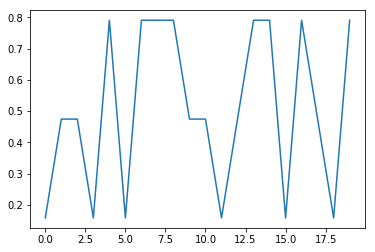

In [150]:
test_signal = np.random.uniform(0, 1, 20)
quantized_test_signal = quantize(test_signal, 3)
plt.plot(quantized_test_signal)

2.2 (5 pts) Write another function that takes the quantized values and computes the "reconstruction" error compared to the original signal.

In [151]:
def compute_reconstruction_error(signal, quantized_signal):
    return np.sum(np.abs(signal-quantized_signal))

In [152]:
print(compute_reconstruction_error(test_signal, quantized_test_signal))

1.705518247794416


2.3 (10 points) Write a function that computes a non-linear transform of the data above to minimize the reconstruction error of the quantized, transformed values.  Explain and illustrate your approach.

In [178]:
# the log function actually works pretty well, so we'll just use that
def transform_signal(signal_in):
    signal = np.copy(signal_in)
    return np.log2(signal)
    #signal.sort()
    #for s, sample in enumerate(signal):
    #    if signal[s] != 0:
    #        signal[s] *= s/len(signal)/signal[s]
    #return signal

def inverse_transform_signal(signal_in):
    signal = np.copy(signal_in)
    #return signal
    return np.square(signal)

not transformed:  263.01741379886727
transformed:  17.463088109522722
transformed and reconstructed:  2486.697031419526


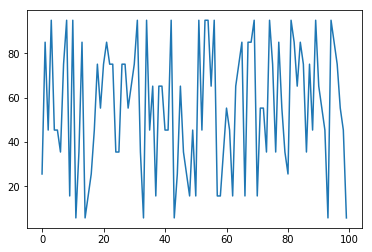

In [188]:
test_signal = np.random.uniform(0, 100, 100)
#print(test_signal)
quantized_test_signal = quantize(test_signal, 10)
transformed_test_signal = transform_signal(test_signal)
#print(transformed_test_signal)
quantized_transformed_test_signal = quantize(transformed_test_signal, 10)
quantized_reconstructed_test_signal = inverse_transform_signal(quantized_transformed_test_signal)
plt.plot(quantized_test_signal)
print("not transformed: ", compute_reconstruction_error(test_signal, quantized_test_signal))
# TODO: is this right now? the transformed quantized relative to transformed is consistently lower, but not reconstructed
# this may be what is meant, or maybe just good enough, in which case delete the last print statement
print("transformed: ", compute_reconstruction_error(transformed_test_signal, quantized_transformed_test_signal))
print("transformed and reconstructed: ", compute_reconstruction_error(test_signal, quantized_reconstructed_test_signal))

2.4 (5 points) Explain how the transform is making optimal use of the capacity of this channel.

2.5 (5 points) Use this function to illustrate coding of the low- and high-entropy signals you used in the previous question.

In [35]:
def entropy_of_image_file(filename, k=5):
    path = 'data/' + filename
    img = imread(path).flatten()
    img = transform_signal(img)
    img = quantize(img, 2**k)
    err = compute_reconstruction_error(img)
    return err

In [145]:
print('low entropy:')
path = 'data/IMG_0697.JPG'
img = imread(path).flatten()
transformed_img = transform_signal(img)
quantized_transformed_img = quantize(transformed_img, 10)
# TODO: make sure this consistent with above
print('reconstruction error: ', compute_reconstruction_error(transformed_img, quantized_transformed_img))
print('high entropy:')
path = 'data/intro_img.png'
img = imread(path).flatten()
transformed_img = transform_signal(img)
quantized_transformed_img = quantize(transformed_img, 10)
# TODO: make sure this consistent with above
print('reconstruction error: ', compute_reconstruction_error(transformed_img, quantized_transformed_img))

low entropy:


/home/iamroot/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: RuntimeWarning: divide by zero encountered in log2
  after removing the cwd from sys.path.
/home/iamroot/anaconda3/lib/python3.7/site-packages/numpy/core/function_base.py:133: RuntimeWarning: invalid value encountered in multiply
  y *= step
/home/iamroot/anaconda3/lib/python3.7/site-packages/numpy/core/function_base.py:142: RuntimeWarning: invalid value encountered in add
  y += start


KeyboardInterrupt: 

### Q3. Coding with Basis Functions (25 points)

3.1 (5 points) Find a toolbox / package for computing 2D wavelet transforms.  Plot the wavelet transform for your images above (or 1D wavelet if you used sounds).  You can either Haar or Daubechies wavelets, but feel free to explore others.

In [189]:
def wavelet_of_image_file(filename, k=5):
    path = 'data/' + filename
    img = imread(path)
    img = rgb2gray(img)
    print(img.shape)
    cwtA, cwtD = pywt.dwt2(img, 'haar') # I'm using pywavelet, because it's nice and lightweight and scipy doesn't do discrete
    return cwtA # CWA, being the approximation coeffs, is what we care about

(1080, 1920)


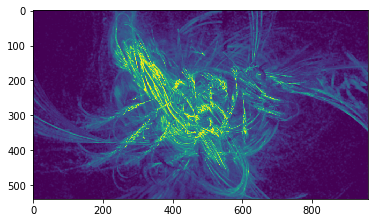

In [190]:
a = wavelet_of_image_file('flam3.png')
plt.imshow(a)
plt.show()

3.2 (10 points) Write a function to plot the wavelet basis functions by apply the inverse transform to delta function in the coeficients.  Use a small (e.g. 8x8 or 16x16) image to limit the number of basis functions you have to plot.

In [276]:
def plot_wavelet_basis_functions(coeffs):
    coeffs = (np.zeros(shape=coeffs[0].shape), (np.zeros(shape=coeffs[1][0].shape), np.zeros(shape=coeffs[1][1].shape), np.zeros(shape=coeffs[1][2].shape)))
    cwtA, cwtD = coeffs[0], coeffs[1]
    cwts = (cwtA, cwtD[0], cwtD[1], cwtD[2])
    for c, cwt in enumerate(cwts):
        for r, cwt_row in enumerate(cwt):
            for v, cwt_coeff in enumerate(cwt_row):
                cwts[c][r][v] = 1.0
                basis_functions = pywt.idwt2(coeffs, 'haar')
                plt.imshow(basis_functions, cmap='gray')
                plt.show()
                cwts[c][r][v] = 0.0

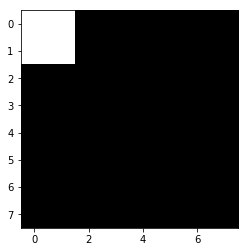

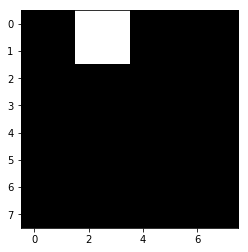

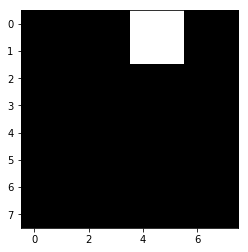

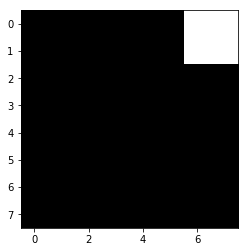

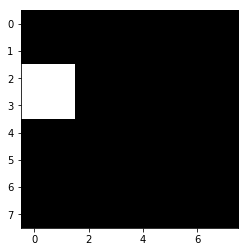

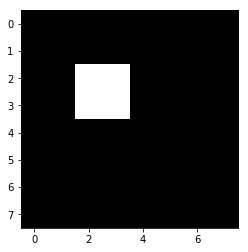

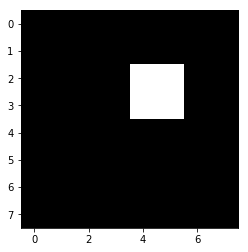

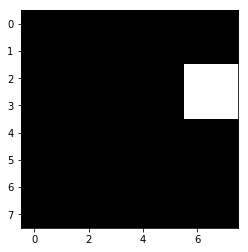

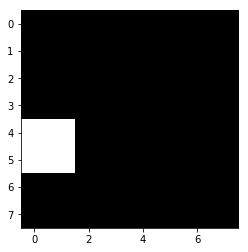

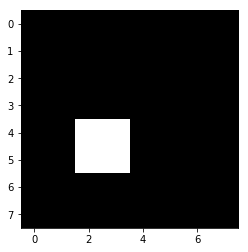

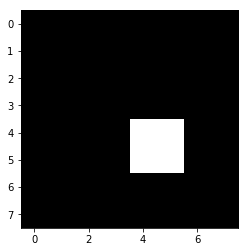

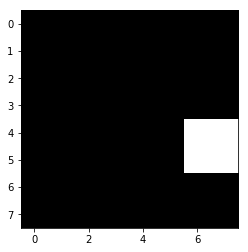

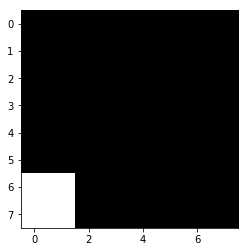

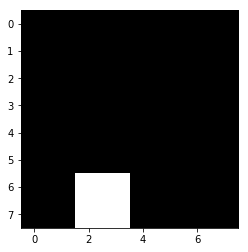

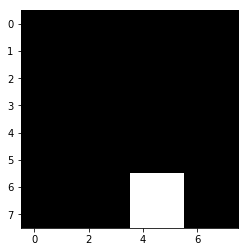

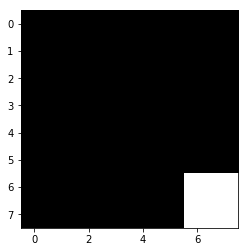

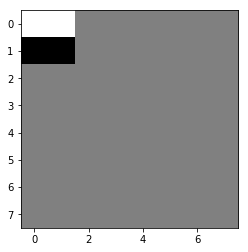

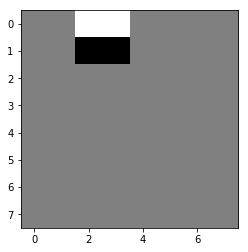

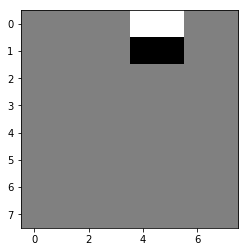

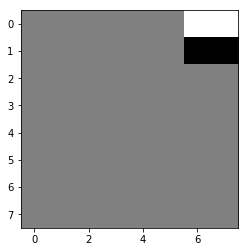

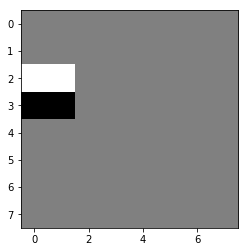

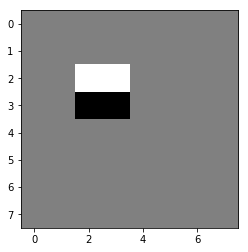

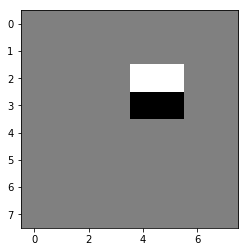

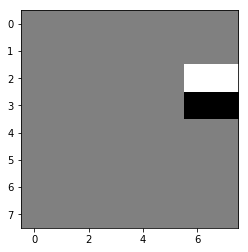

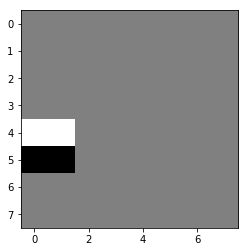

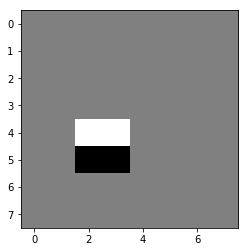

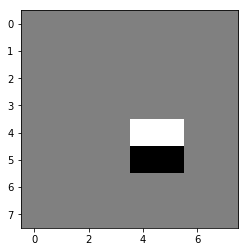

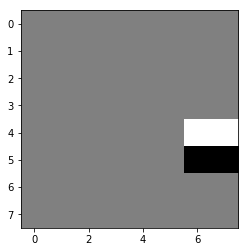

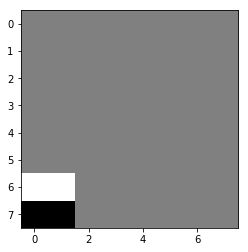

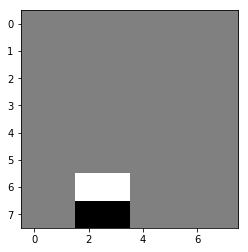

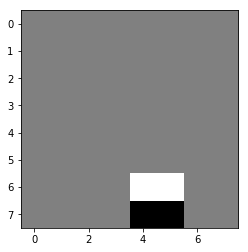

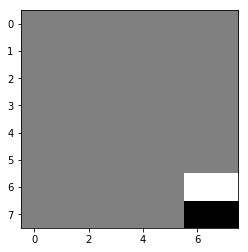

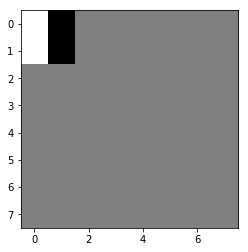

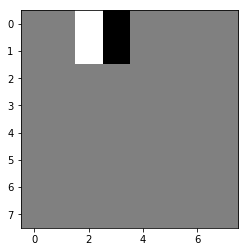

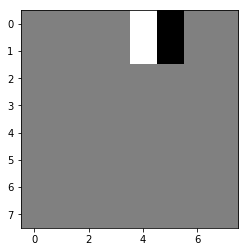

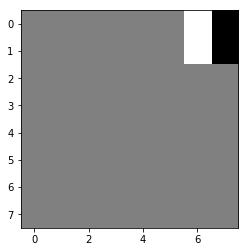

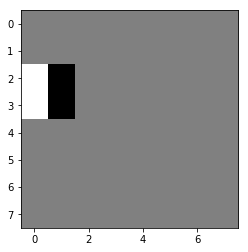

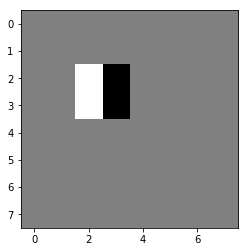

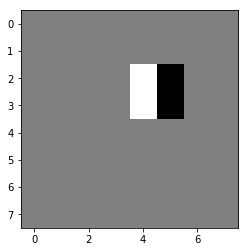

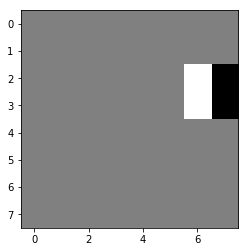

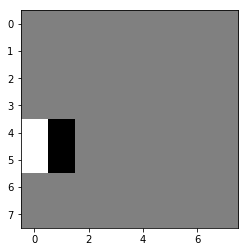

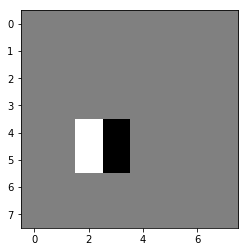

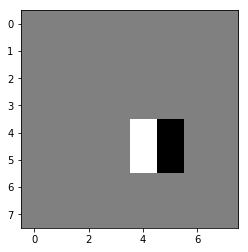

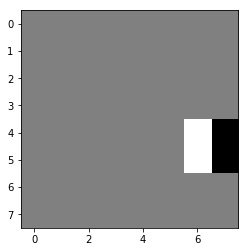

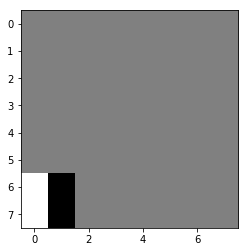

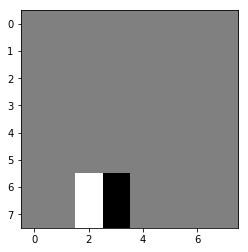

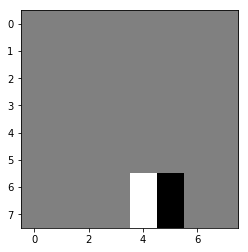

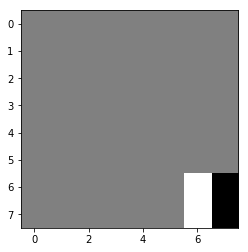

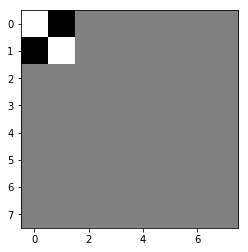

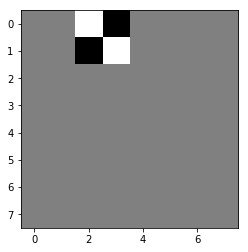

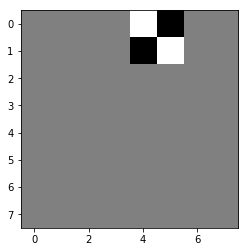

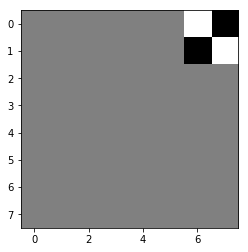

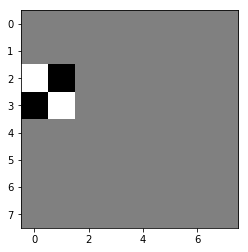

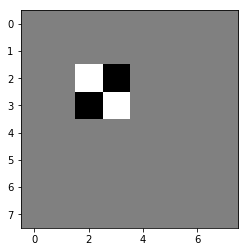

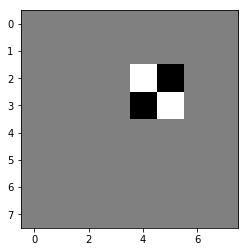

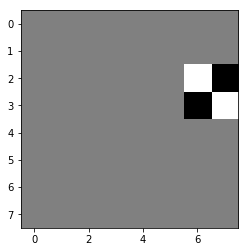

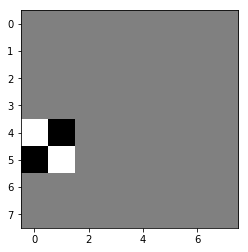

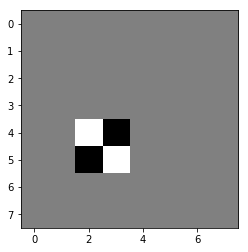

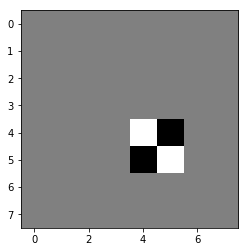

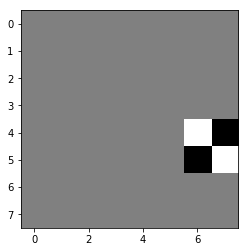

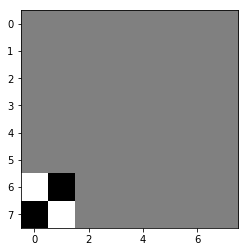

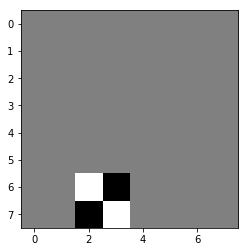

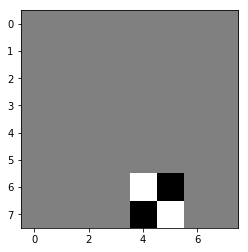

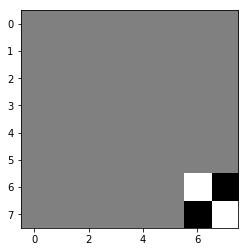

In [278]:
path = 'data/face.png'
img = imread(path)
img = rgb2gray(img)
cwtA, cwtD = pywt.dwt2(img, 'haar')
plot_wavelet_basis_functions((cwtA, cwtD))

3.3 (10 points) Apply your quantization coding functions above to the wavelet coefficients and illustrate how this code compares to coding the quantized pixels.

In [294]:
# apply quantization to wavelet coefficients
bandwidth = 10
q_cwtA, q_cwtD = quantize(cwtA.flatten(), bandwidth), (quantize(c.flatten(), bandwidth) for c in cwtD)

# compare to coding quantized pixels directly
# TODO: as with Q2, make sure this matches
wavelet_err = compute_reconstruction_error(cwtA.flatten(), q_cwtA) + \
    np.sum((compute_reconstruction_error(c.flatten(), q) for c, q in zip(cwtD, q_cwtD)))
q_img = quantize(img.flatten(), bandwidth)
pixel_err = compute_reconstruction_error(img.flatten(), q_img)

print('Pixel reconstruction error: ', pixel_err)
print('Wavelet reconstruction error: ', wavelet_err)
# TODO: should they actually be the same?

Pixel reconstruction error:  3.200000000000002
Wavelet reconstruction error:  3.2000000000000024


/home/iamroot/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:7: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.from_iter(generator)) or the python sum builtin instead.
  import sys


### Q4. Exploration (15 points)

In this section, you are meant to do creative exploration.  Select a concept or topic you want to understand better that is related to the problems in this assignment or is in the readings.  Explore it, and write up and illustrate what you tried and learned.  The general idea is for you to teaching yourself, and it should read like a (relatively brief) tutorial.

Here is the grading rubric:

- Was the topic clearly described and concise? (5 pts)

- Were the relevant concepts clearly explained? (5 pts)

- Did the problem go beyond or is distinct from what was already convered in the questions above? (5 pts)

Here I compare a few different signal encoding schemes, namely PCA, ICA and Wavelet Transform, in terms of their entropy and reconstruction loss.

In [50]:
path = 'data/flam3.png'
img = imread(path)
img = rgb2gray(img) # convert to grayscale to make it run faster and work better with sklearn
print(img.shape)

(1080, 1920)


In [131]:
class PCAEncoder:
    
    label = 'PCA'
    
    def __init__(self, bandwidth):
        self.pca = PCA(n_components=bandwidth)
    
    def encode(self, x):
        return self.pca.fit_transform(x)
    
    def decode(self, x):
        return self.pca.inverse_transform(x)


class ICAEncoder:
    
    label = 'ICA'
    
    def __init__(self, bandwidth):
        self.ica = ICA(n_components=bandwidth)
    
    def encode(self, x):
        return self.ica.fit_transform(x)
    
    def decode(self, x):
        return self.ica.inverse_transform(x)


class WaveletEncoder:
    
    label = 'Wavelet'
    
    def __init__(self, bandwidth):
        pass
    
    def encode(self, x):
        self.cA, self.cD = pywt.dwt2(x, 'haar')
        return self.cA
    
    def decode(self, x):
        return pywt.idwt2((x, self.cD), 'haar')

# NOTE: we can't easily parameterize the discrete wavelet transform well to fit a given signal bandwidth
encoder_types = [PCAEncoder, ICAEncoder, WaveletEncoder]

In [132]:
# plot reconstruction loss over entropy
reconstruction_losses = []
entropies = []

for encoder_type in encoder_types:
    reconstruction_losses.append([])
    entropies.append([])
    for bandwidth in (10, 25, 50):
        encoder = encoder_type(bandwidth)
        encoded = encoder.encode(img)
        decoded = encoder.decode(encoded)
        reconstruction_loss = np.sum(abs(np.square(img) - np.square(decoded)))
        print(reconstruction_loss)
        reconstruction_losses[-1].append(reconstruction_loss)
    
        counts = compute_histogram(encoded, hist_range=(-4, 4))[0]
        ent = entropy(counts)
        print(ent)
        entropies[-1].append(ent)

61692.66268781418
2.674826424678941
46642.925516291514
2.1495247441331005
33769.54797075295
1.7563903568203478
61692.91478467516
0.9954849115885656


/home/iamroot/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: RuntimeWarning: divide by zero encountered in log2
  after removing the cwd from sys.path.
/home/iamroot/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: RuntimeWarning: invalid value encountered in multiply
  """


46641.206231702075
0.999880163938298
33762.98083404486
0.9999926816251272
7.580874531473112e-11
0.5941853674424047
7.580874531473112e-11
0.5941853674424047
7.580874531473112e-11
0.5941853674424047


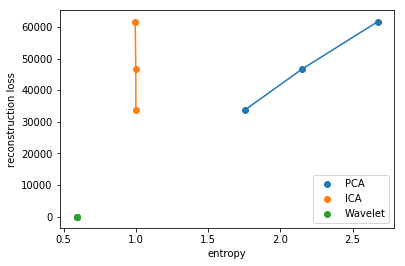

In [133]:
for e, encoder_type in enumerate(encoder_types):
    plt.scatter(entropies[e], reconstruction_losses[e], label=encoder_type.label)
    plt.plot(entropies[e], reconstruction_losses[e])
    plt.legend()
    plt.xlabel('entropy')
    plt.ylabel('reconstruction loss')

plt.show()